# Classifcation Project

## Data Import

In [188]:
import pandas as pd
# Load data into pandas DataFrame from "/lakehouse/default/Files/train.csv"
df_original = pd.read_csv("/lakehouse/default/Files/train.csv")
display(df_original)


In [189]:
y_original = pd.read_csv("/lakehouse/default/Files/train_churn_labels.csv")
display(y_original)

In [230]:
y = y_original

In [231]:
y.value_counts()

Label
-1       46328
 1        3672
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X_1, X_2, y_1, y_2 = train_test_split(
    df_original, y_original, 
    test_size=0.5, 
    random_state=42, 
    shuffle=False
)

In [ ]:
X_1.to_csv("/lakehouse/default/Files/X_1.csv", index=False)
X_2.to_csv("/lakehouse/default/Files/X_2.csv", index=False)
y_1.to_csv("/lakehouse/default/Files/y_1.csv", index=False)
y_2.to_csv("/lakehouse/default/Files/y_2.csv", index=False)
print("File successfully saved")

File successfully saved


## Data Exploration

### Missing values

Dropping columns with > 70% missing values

In [190]:
# Calculate the minimum number of non-null values required (30% of total rows)
df = df_original
limit = len(df) * 0.3

# axis=1 drops columns; thresh=limit keeps columns with at least 30% valid data
df = df.dropna(axis=1, thresh=limit)

In [191]:
display(df.head())

In [192]:
# Calculate percentage, sort descending, and take top 10
missing_values = df.isnull().mean().sort_values(ascending=False) * 100
print(missing_values.head(10))

Var189    57.956
Var229    56.864
Var225    52.288
Var214    50.816
Var200    50.816
Var72     44.760
Var94     44.760
Var126    27.840
Var149    14.460
Var24     14.460
dtype: float64


In [193]:
# Calculate percentage, sort descending, and take top 10
missing_values = df.isnull().mean().sort_values(ascending=True) * 100
print(missing_values.head(10))

Var212    0.0
Var211    0.0
Var210    0.0
Var207    0.0
Var228    0.0
Var73     0.0
Var220    0.0
Var221    0.0
Var113    0.0
Var193    0.0
dtype: float64


In [194]:
df.to_csv("/lakehouse/default/Files/processed_data_1.csv", index=False)

print("File successfully saved")

File successfully saved


### Data Correlation

In [195]:
import numpy as np

# 1. Calculate the correlation matrix
corr_matrix = df.corr(numeric_only=True)

# 2. Get unique pairs by masking the lower triangle and the diagonal
# We use np.triu to keep only the upper triangle of the matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Stack to a Series, take absolute values for strength, and sort
top_10 = upper_tri.stack().abs().sort_values(ascending=False).head(10)

print("Top 10 Highly Correlated Variable Pairs:")
print(top_10)


Top 10 Highly Correlated Variable Pairs:
Var21   Var22     1.000000
Var22   Var160    0.927281
Var21   Var160    0.926964
Var22   Var25     0.886206
Var21   Var25     0.885979
        Var123    0.885950
Var22   Var123    0.885477
        Var112    0.827518
Var21   Var112    0.826865
Var109  Var112    0.824292
dtype: float64


Dropping highly correlated columns: `Var21`

In [196]:
df_uncorr = df.drop('Var21', axis=1)

df_uncorr.to_csv("/lakehouse/default/Files/processed_data_2.csv", index=False)

print("File successfully saved")

File successfully saved


In [197]:
import numpy as np

# 1. Calculate the correlation matrix
corr_matrix = df_uncorr.corr(numeric_only=True)

# 2. Get unique pairs by masking the lower triangle and the diagonal
# We use np.triu to keep only the upper triangle of the matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# 3. Stack to a Series, take absolute values for strength, and sort
top_10 = upper_tri.stack().abs().sort_values(ascending=False).head(10)

print("Top 10 Highly Correlated Variable Pairs:")
print(top_10)


Top 10 Highly Correlated Variable Pairs:
Var22   Var160    0.927281
        Var25     0.886206
        Var123    0.885477
        Var112    0.827518
Var109  Var112    0.824292
Var78   Var132    0.805602
Var22   Var83     0.804572
        Var109    0.802470
Var85   Var109    0.797780
Var25   Var160    0.790594
dtype: float64


In [198]:
display(df_uncorr.head())

Use Data Wrangler on `df_uncorr` for further analysis

### Binning

The `Var192`, `Var193` ... are categorical variables. Dropping categorical variables with > 10 distinct counts

In [199]:
# 1. Identify categorical columns (usually 'object' or 'category' type)
cat_cols = df_uncorr.select_dtypes(include=['object', 'category']).columns

# 2. Identify those with more than 10 unique values
cols_to_drop = [col for col in cat_cols if df_uncorr[col].nunique() > 10]

# 3. Drop the identified columns
df_new = df_uncorr.drop(columns=cols_to_drop)

display(df_new)


In [200]:
cat_cols

Index(['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199',
       'Var200', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var214', 'Var216', 'Var217',
       'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var225',
       'Var226', 'Var227', 'Var228', 'Var229'],
      dtype='object')

Creating 10 bins for numerical columns

In [201]:
# 1. Identify numerical columns
num_cols = df_new.select_dtypes(include=['number']).columns

# 2. Convert each numerical column into 10 equal-width bins
for col in num_cols:
    # We append '_binned' to the column name to keep the original data
    df_new[f'{col}_binned'] = pd.cut(df_new[col].to_numpy(), bins=10, labels=False)

print(f"Binned columns created for: {list(num_cols)}")

Binned columns created for: ['Var6', 'Var7', 'Var13', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var72', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var94', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var126', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var189']


In [202]:
df_binned = df_new.drop(columns=num_cols)
X = df_binned
display(X)

This is our input data

## Model fitting

In [203]:
# Importing libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier, Pool
import xgboost as xgb


### Model 1 = RandomForestClassifier

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


### Model 2 = DecisionTree

> **Use Label Encoding** ONLY if your categories have a natural rank (Ordinal data) or if you are using a Tree-based model and want to keep the dataset size small.
Use One-Hot Encoding for unordered categories (Nominal data) to prevent the model from assuming a fake ranking.
Use Native Handling if using CatBoost or LightGBM, as it is often more accurate than manual encoding.

> **Column Count:** Your LabelEncoder code kept the number of columns the same. This One-Hot code will increase the number of columns (one for each unique value in each categorical column).
Linear Models: If you are using Logistic Regression or SVM, One-Hot Encoding is mandatory over Label Encoding.
Tree Models: If you are using Decision Trees or Random Forest, Label Encoding is often sufficient, but One-Hot can sometimes improve accuracy if the number of categories is small.



In [206]:
# 1. Handle Categorical Data (Fixes 'could not convert string to float')
# Identify columns that are strings/objects
cat_cols = X.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in cat_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# 2. Split Data train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize and Fit the Model
# 'max_depth' prevents the tree from growing too large (overfitting)
model = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
model.fit(X_train, y_train)

# 4. Predict and Evaluate
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


🏃 View run crimson_bottle_z3b6yh9g at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/de1531ff-ffbe-4e5b-b57e-89140ac5a1d4
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


Accuracy: 0.93

Classification Report:
               precision    recall  f1-score   support

          -1       0.93      1.00      0.96      9305
           1       0.54      0.02      0.04       695

    accuracy                           0.93     10000
   macro avg       0.74      0.51      0.50     10000
weighted avg       0.90      0.93      0.90     10000



### Model 3 = CatBoost

In [ ]:
# 1. Identify Categorical Features
# CatBoost works best when you explicitly tell it which columns are categorical
cat_features = list(X.select_dtypes(include=['object', 'category']).columns)

# 2. Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Initialize CatBoost
# 'iterations' is the number of trees, 'learning_rate' is step size
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    verbose=100  # Prints progress every 100 iterations
)

# 4. Fit Model
# You MUST pass the cat_features list here
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    plot=False # Set to True if working in a Jupyter Notebook for live graphs
)

# 5. Predict and Evaluate
y_pred = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


### Model 4 = XGBoost

In [ ]:
# 1. Prepare Data: Convert 'object' columns to 'category' type
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

y_hash = y.replace(-1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y_hash, test_size=0.2, random_state=42)

# 2. Initialize and Train
# enable_categorical=True is required for automatic string handling
model_xgb = xgb.XGBClassifier(
    tree_method="hist", 
    enable_categorical=True, 
    n_estimators=100,
    max_depth=6
)

model_xgb.fit(X_train, y_train)

# 3. Predict
y_pred = model_xgb.predict(X_test)
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


## Feature Engineering

### Treating missing values

In [207]:
display(X.head())

In [208]:
# Impute NaN with the mode for all columns
# .mode() returns a DataFrame, so we take the first row (index 0)
X_filled = X.fillna(X.mode().iloc[0])

# Verify there are no more NaNs
print(X_filled.isnull().sum().sum())

0


In [209]:
display(X_filled)

### Label Encoding

In [210]:
X_encoded = X_filled

# 1. Handle Categorical Data (Fixes 'could not convert string to float')
# Identify columns that are strings/objects
cat_cols = X_encoded.select_dtypes(include=['object']).columns

le = LabelEncoder()
for col in cat_cols:
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

### Feature importance

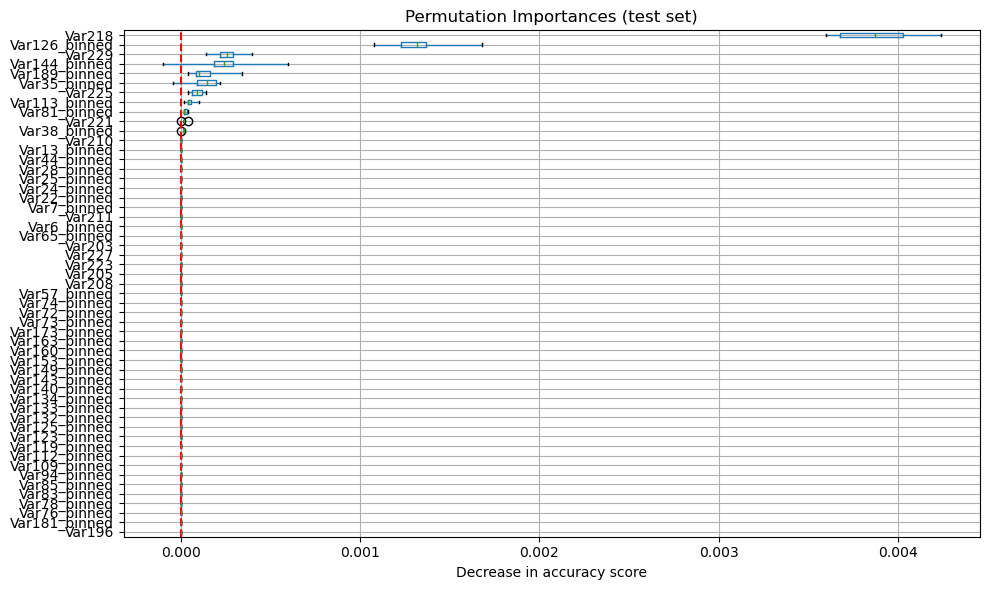

In [211]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


# 3. Calculate Permutation Importance on the test set
# n_repeats defines how many times each feature is shuffled
result = permutation_importance(model, X_encoded, y, n_repeats=10, random_state=42, n_jobs=-1)

# 4. Create a DataFrame for visualization
sorted_idx = result.importances_mean.argsort()
perm_imp_df = pd.DataFrame(
    result.importances[sorted_idx].T,
    columns=X_encoded.columns[sorted_idx],
)

# 5. Plot the result
plt.figure(figsize=(10, 6))
perm_imp_df.boxplot(vert=False, whis=10)
plt.title("Permutation Importances (test set)")
plt.axvline(x=0, color="red", linestyle="--")
plt.xlabel("Decrease in accuracy score")
plt.tight_layout()
plt.show()

In [212]:
# 1. Get the indices of the features sorted by mean importance (descending)
# result.importances_mean.argsort() returns indices in ascending order
# [::-1] reverses it to descending, and [:5] takes the top five
top_indices = result.importances_mean.argsort()[::-1][:5]

# 2. Extract names and their corresponding importance scores
top_5_features = X_encoded.columns[top_indices]
top_5_scores = result.importances_mean[top_indices]

# 3. Display as a clean DataFrame
top_5_df = pd.DataFrame({
    'Feature': top_5_features,
    'Importance Mean': top_5_scores,
    'Importance Std': result.importances_std[top_indices]
})

print("Top 5 Features by Permutation Importance:")
print(top_5_df)


Top 5 Features by Permutation Importance:
         Feature  Importance Mean  Importance Std
0         Var218         0.003874        0.000205
1  Var126_binned         0.001330        0.000167
2         Var229         0.000262        0.000071
3  Var144_binned         0.000242        0.000165
4  Var189_binned         0.000136        0.000084


### Feature selection

In [213]:
import pandas as pd

# 1. Identify indices where mean importance is greater than 0
positive_idx = result.importances_mean > 0

# 2. Extract the names of these specific features
# Ensure you use the columns from the original X used in the importance test
positive_features = X_encoded.columns[positive_idx]

# 3. Create the new DataFrame with only selected columns
# The correct syntax is X[list_of_columns]
X_selected = X_encoded[positive_features]

# Verify the result
print(f"Original feature count: {X.shape[1]}")
print(f"Selected feature count: {X_selected.shape[1]}")
print("Selected Columns:", list(X_selected.columns))


Original feature count: 53
Selected feature count: 11
Selected Columns: ['Var218', 'Var221', 'Var225', 'Var229', 'Var35_binned', 'Var38_binned', 'Var81_binned', 'Var113_binned', 'Var126_binned', 'Var144_binned', 'Var189_binned']


In [214]:
display(X_selected)

In [215]:
X_selected.shape

(50000, 11)

In [ ]:
pip install imbalanced-learn

## Model Training

### LightGBM + 5 fold Cross Validation + SMOTE

In [226]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

# 1. Setup 5-fold Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_recalls = []

X = X_selected
y = y.replace(-1, 0).values.ravel()

# 2. Iterate through folds
for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
    
    # Split data
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # 3. Apply SMOTE ONLY on training data
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    
    # 4. Train LightGBM
    model = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=300,
        learning_rate=0.05,
        class_weight=None,   # SMOTE already balances
        random_state=42,
        verbose=-1
    )
    
    model.fit(X_train_res, y_train_res)
    
    # 5. Predict & Recall (Class 1)
    y_prob = model.predict_proba(X_val)[:, 1]
    y_pred = (y_prob >= 0.3).astype(int) 
    # y_pred = model.predict(X_val)
    recall = recall_score(y_val, y_pred)
    
    fold_recalls.append(recall)
    
    print(f"Fold {fold} Recall (Class 1): {recall:.4f}")

print("\nMean Recall across 5 folds:", np.mean(fold_recalls))


🏃 View run stoic_tail_1p9q1xyd at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/9d64acf7-2aa8-4cac-b87d-8430703e2792
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


🏃 View run amiable_tiger_cmxvmgyy at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/2134e5d7-7f31-4b41-81fd-e7e41aaf3eb8
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


Fold 1 Recall (Class 1): 0.6253
🏃 View run epic_picture_qvhnvl49 at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/c20e1a69-5a7a-4ec2-88e5-343ad2cd58ab
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


🏃 View run busy_nutmeg_vt71f8cr at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/08ab3681-27cd-4b91-a043-664fd8a8a7e3
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


Fold 2 Recall (Class 1): 0.6281
🏃 View run tough_beard_tkgj2fdk at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/d0d685d8-34d9-43c1-b2e0-cf9218240945
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


🏃 View run hungry_yacht_rk2sss2q at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/bcb407a7-6c36-4285-93f6-44289f6cafd0
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


Fold 3 Recall (Class 1): 0.5967
🏃 View run lime_brush_6ktgpn27 at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/3aff9f52-7ea6-4450-bbdc-85369626561d
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


🏃 View run yellow_eagle_vv68vtd6 at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/f826ed9a-9e4f-4f17-9f0f-38f4cf16cb5b
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


Fold 4 Recall (Class 1): 0.6204
🏃 View run clever_card_gccyjtjk at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/b4ae9fca-e558-462f-bde9-b7583ae939da
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


🏃 View run purple_oven_w2g0p707 at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638/runs/4a893f31-55b2-4821-8c9f-511ab947efbe
🧪 View experiment at: https://pbipwestus31-westus3.pbidedicated.windows.net/webapi/capacities/645f007a-8023-4dcd-8788-95742873b8a2/workloads/ML/ML/Automatic/workspaceid/65f78450-98dd-430b-893d-346971a9c5a4/#/experiments/6b364a3a-1601-4d76-9c36-aea0bc858638


Fold 5 Recall (Class 1): 0.6395

Mean Recall across 5 folds: 0.6220000370720495


## Model Evaluation

Precision-Recall AUC: 0.1407


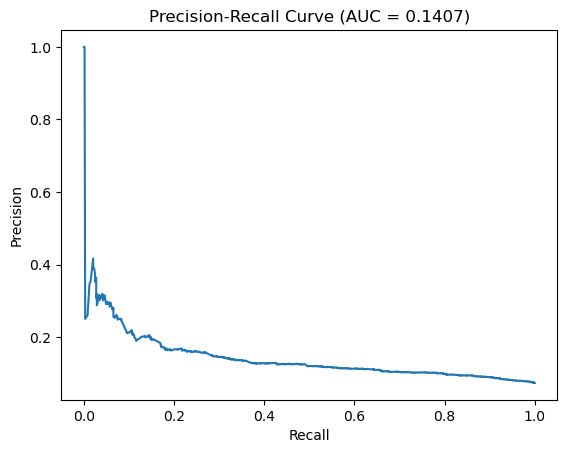

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Predict probabilities for positive class (1)
y_prob = model.predict_proba(X_val)[:, 1]

# Precision-Recall values
precision, recall, thresholds = precision_recall_curve(y_val, y_prob)

# PR-AUC score
pr_auc = average_precision_score(y_val, y_prob)

print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.4f})")
plt.show()


In [ ]:
# Baseline PR-AUC = 3672 / 50000 = 0.0734
# PR-AUC score = 0.14

# Hence the model is significant

---

## 🧠 What Does Precision-Recall AUC Impose?

### 🔹 Definition

**PR-AUC measures how well the model balances Precision and Recall across ALL classification thresholds**, not just at 0.5.

---

## 🔴 Why PR-AUC Is CRITICAL for Imbalanced Data

### Your Dataset Example

| Class | Count |
| ----- | ----- |
| 0     | 940   |
| 1     | 60    |

---

### 1️⃣ ROC-AUC Can Be Misleading

ROC-AUC focuses on **True Negative Rate**, which is inflated when Class 0 dominates.

📌 A bad model can still score **high ROC-AUC** by correctly predicting mostly zeros.

---

### 2️⃣ PR-AUC Focuses ONLY on Minority Class

PR-AUC **ignores true negatives** and answers:

> “When the model predicts a 1, how often is it correct (Precision), and how many actual 1s did it find (Recall)?”

✔ Exactly what matters in imbalanced problems.

---

### 3️⃣ Baseline Matters

The **baseline PR-AUC = positive class ratio**

```
Baseline PR-AUC = 3672 / 50000 = 0.073
```

| PR-AUC Score | Meaning         |
| ------------ | --------------- |
| ~0.07        | Random guessing |
| 0.20         | Useful model    |
| 0.40+        | Strong model    |
| 0.60+        | Excellent       |

---

### 4️⃣ Threshold-Independent Metric

Accuracy, Precision, Recall depend on **threshold choice** (0.5 by default).

PR-AUC evaluates **all thresholds**, making it:

* More stable
* More realistic
* Better for model comparison

---

## 📊 Metric Comparison (Imbalanced Data)

| Metric           | Useful? | Why                    |
| ---------------- | ------- | ---------------------- |
| Accuracy         | ❌       | Ignores minority class |
| ROC-AUC          | ⚠️      | Inflated by Class 0    |
| Recall (Class 1) | ✅       | Finds rare events      |
| Precision        | ✅       | Reduces false alarms   |
| **PR-AUC**       | ⭐⭐⭐     | Best overall indicator |

---

## 💼 Interview-Ready Explanation (Use This)

> “Precision-Recall AUC is preferred for imbalanced datasets because it evaluates how well the model identifies the minority class across all thresholds, without being influenced by the abundance of true negatives. A PR-AUC significantly higher than the class prevalence indicates real predictive power.”

---


# Churn Dataset Overview

A **churn dataset** is a structured collection of historical customer information used to identify patterns in **customer attrition**—the phenomenon where customers stop using a company’s products or services.

## Class Imbalance in Churn Data
Most churn datasets are inherently **imbalanced** because, in a healthy business, only a small fraction of customers (typically **5%–20%**) churn within a given time period. This imbalance requires specialized modeling techniques and evaluation metrics focused on minority-class detection.

## Modeling Approach in 2025
In 2025, **Gradient Boosted Decision Trees (GBDTs)** such as **XGBoost**, **LightGBM**, and **CatBoost** are the industry standard for churn prediction.

Unlike traditional time-series models (e.g., **ARIMA**), GBDTs frame churn prediction as a **supervised learning problem** by leveraging **lag-based features** that capture historical customer behavior.

## Time-Based Churn Prediction
For predicting churn at a specific point in time, these models analyze a behavioral **snapshot**—such as customer usage, engagement, or transactions over the **previous 30 days**—to estimate the likelihood of churn in the **next 30 days**, delivering strong performance and scalability in real-world systems.

Churn prediction has moved beyond simple classification toward temporal forecasting. The latest models combine the high performance of Gradient Boosting with the sequential awareness of Deep Learning to predict not just if a customer will churn, but when.
The follow


Below is a **churn prediction confusion matrix** followed by a **clear explanation of why Recall is critical**, along with how other metrics should be interpreted in an imbalanced churn setting.

---

## Confusion Matrix – Churn Prediction

Assume:

* **Class 1 = Churned customer**
* **Class 0 = Retained customer**

```
                      Predicted
                 ┌───────────┬───────────┐
                 │   No Churn │   Churn   │
┌───────────────┼───────────┼───────────┤
│ Actual No     │    TN      │    FP     │
│ Churn (0)     │ (Correct)  │ (False    │
│               │            │  Alarm)   │
├───────────────┼───────────┼───────────┤
│ Actual Churn  │    FN      │    TP     │
│ (1)           │ (Missed    │ (Correct  │
│               │  Churn)    │  Catch)   │
└───────────────┴───────────┴───────────┘
```

---

## Why **Recall for Churn (Class 1)** Is the Most Important Metric

### 1. Business Cost of False Negatives

* **False Negative (FN)** = A customer churned, but the model predicted “No Churn”
* This means **no retention action was taken**
* Lost revenue + lost lifetime value
* In churn use cases, **missing a churner is far more expensive** than wrongly flagging a loyal customer

### 2. What Recall Measures

```
Recall (Churn) = TP / (TP + FN)
```

* Answers: **“Out of all customers who actually churned, how many did we catch?”**
* High recall ensures **maximum coverage of at-risk customers**
* Especially critical when churn rate is low (5–10%)

---

## Role of Other Metrics (and Their Trade-offs)

### Precision (Churn)

```
Precision = TP / (TP + FP)
```

* Measures how many predicted churners actually churned
* Important to **avoid over-targeting** customers
* Trade-off: Increasing recall often lowers precision

### Accuracy (Why It’s Misleading)

* In a dataset with 90% non-churners:

  * Predicting “No Churn” for everyone → **90% accuracy**
  * **0% recall for churn**
* Accuracy hides model failure in imbalanced datasets

### F1 Score

```
F1 = 2 × (Precision × Recall) / (Precision + Recall)
```

* Balances precision and recall
* Useful when **both catching churners and avoiding false alarms matter**

### PR-AUC (Precision–Recall AUC)

* Best metric for **highly imbalanced churn data**
* Focuses only on churn class performance
* Indicates how well the model separates churners from non-churners across thresholds

---

## Summary: Metric Priority for Churn Models

| Metric         | Importance | Reason                     |
| -------------- | ---------- | -------------------------- |
| **Recall (1)** | ⭐⭐⭐⭐⭐      | Avoid missing churners     |
| PR-AUC         | ⭐⭐⭐⭐☆      | Best imbalance indicator   |
| F1 Score       | ⭐⭐⭐☆☆      | Balance precision & recall |
| Precision      | ⭐⭐⭐☆☆      | Control targeting cost     |
| Accuracy       | ⭐☆☆☆☆      | Misleading                 |

---

### Key Takeaway

> **In churn prediction, a model that misses churners is worse than a model that raises false alarms.**
> That is why **Recall for Class 1 is the most critical metric**, supported by PR-AUC and F1 Score.

If you want, I can also:

* Draw this as a **diagram**
* Show **metric trade-offs using threshold tuning**
* Map metrics to **business actions (retention campaigns)**


### Recall as Metric

### Why Recall for Class 1 Is Critical in a Highly Imbalanced Dataset (94% vs 6%)

In a dataset where **94% (940)** of records belong to **Class 0** and only **6% (60)** belong to **Class 1**, **Recall for Class 1** is the **most critical metric**. It measures the model’s ability to actually detect the **rare events you care about**.

---

### 1️⃣ Accuracy Is a “Trap”
With this imbalance, a naive model that predicts **Class 0 for every record** will achieve:

- **Accuracy = 94%**
- **Recall (Class 1) = 0**

Despite the high accuracy, the model is **completely useless** because it fails to identify **any** Class 1 cases. Accuracy gives a **false sense of success** in imbalanced datasets.

---

### 2️⃣ Measuring “Catchment” (Finding the Needle in the Haystack)
Recall for Class 1 (also called **Sensitivity**) answers:

> *“Out of all actual Class 1 cases, how many did the model correctly identify?”*

Examples:
- **Recall₁ = 0.10** → You caught **6 out of 60**
- **Recall₁ = 0.90** → You caught **54 out of 60**

In domains like **fraud detection, disease diagnosis, churn prediction, or equipment failure**, missing a true Class 1 is far more costly than flagging extra Class 0s.

---

### 3️⃣ The Cost of False Negatives
A **False Negative** (predicting 0 when the true class is 1) means:
- A fraud goes undetected
- A disease is not diagnosed
- A failure happens without warning

High **Recall for Class 1** minimizes these missed opportunities and directly reduces real-world risk.

---

### 4️⃣ Better Model Tuning & Modern (2025) Techniques
Optimizing for Recall₁ justifies using imbalance-handling techniques such as:

- **SMOTE / Oversampling**  
  Create synthetic Class 1 samples so the model learns minority patterns.
  
- **Class Weights**  
  Penalize misclassifying Class 1 more heavily (e.g., missing a ‘1’ is 15× worse than missing a ‘0’).
  
- **Threshold Moving**  
  Lower the probability cutoff for predicting Class 1 to capture more positives.

---

### ✅ Key Takeaway
> In highly imbalanced datasets, **Recall for the minority class** is the most meaningful metric because it directly measures how well the model detects rare but critical events—something accuracy cannot reveal.

